In [9]:
import pandas as pd

In [12]:
data = pd.read_excel("../data/raw/DFSS_GB_Wk1_Rev16/Manufacturing Data.xlsx")

In [112]:
import numpy as np

def calculate_process(x, LSL, USL, window=10):
    mu = x.mean()
    std = x.std()
    rolling_mean = x.rolling(window).mean()
    std_within = (x - rolling_mean).std()

    ppk = np.min([
        (USL-mu)/(3*std),
        (mu-LSL)/(3*std)
    ])
    
    cpk = np.min([
        (USL-mu)/(3*std_within),
        (mu-LSL)/(3*std_within)
    ])

    d = {
        "mean": mu,
        "std": std,
        "ppk": ppk,
        "cpk": cpk
    }
    return pd.Series(d, index=['mean', 'std', 'ppk', 'cpk'])

In [113]:
calculate_process(data.Final, LSL=21, USL=24)

mean    23.905522
std      0.497079
ppk      0.063355
cpk      0.092406
dtype: float64

# Calculating $P_{pk}$ and $C_{pk}$

The difference between $P_{pk}$ and $C_{pk}$ is the definition of the standard deviation; for the former, we want to use the overall standard deviation, and for the latter, we want to use the standard deviation within a subgroup, meaning, devoid of a mean shifts.

In the below plot we plot the raw signal, then use a rolling mean and calculate the standard deviation of the signal offset by the rolling mean. $\sigma_{within}$ is then calculated from the processed signal.

(0.4970793350979102, 0.3408079336795284)

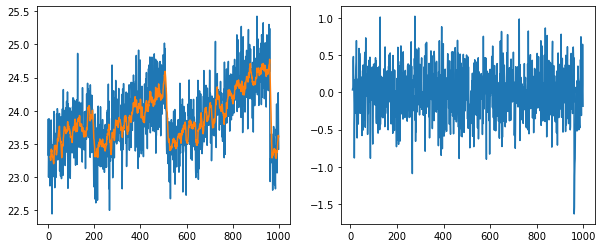

In [114]:
import pylab as pl

window = 10
rolling_mean = data.Final.rolling(window).mean()

fig, (ax1, ax2) = pl.subplots(1,2,figsize=(10,4))
ax1.plot(data.Final)
ax1.plot(rolling_mean)
ax2.plot(data.Final - rolling_mean)

sigma_overall, sigma_within = data.Final.std(), (data.Final - rolling_mean).std()
sigma_overall, sigma_within